# 군집분석

## 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv('D:\Machine Learning\ADP-master\data/bikeshare.csv')

# type별로 컬럼 분류
col_id = []
col_dt = ['datetime']
col_cat = ['season']
col_int = ['weather', 'humidity','casual','registered','count']
col_float = ['temp','atemp','windspeed']
col_bool = ['holiday','workingday']

col_num = col_int + col_float
data['datetime'] = pd.to_datetime(data['datetime'])
data[col_cat]= data[col_cat].astype('str')
data[col_int] = data[col_int].astype('int', errors='ignore')
data[col_float] = data[col_float].astype('float')

data.loc[data['count'] <= 150, 'y1'] = 0
data.loc[(data['count']>150)&(data['count'] <= 300), 'y1'] = 1
data.loc[(data['count']>300)&(data['count'] <= 450), 'y1'] = 2
data.loc[data['count'] > 450, 'y1'] = 3
Data=data[['holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'y1']]
x_data=Data.drop(['y1'], axis=1, inplace=False)
y_data=Data['y1']

## Kmeans, MeanShift, GMM, DBSCAN

In [2]:
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN, AgglomerativeClustering #Kmeans, MeanShift, DBSCAN
from sklearn.mixture import GaussianMixture #GMM 군집화 : 여러개 가우시안 분포가 섞임, 확률 기반 군집화

kmeans=KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=0) #Kmeans
bandwidth=estimate_bandwidth(x_data, quantile=0.2) #MeanShift
bw=round(bandwidth,3)
meanshift=MeanShift(bandwidth=bw)
gmm=GaussianMixture(n_components=3, random_state=0) #GMM
dbscan=DBSCAN(eps=0.6, min_samples=8, metric='euclidean') #DBSCAN

kmeans_labels=kmeans.fit_predict(x_data)
meanshift_labels=meanshift.fit_predict(x_data)
gmm_labels=gmm.fit_predict(x_data)
dbscan_labels=dbscan.fit_predict(x_data)


x_data['cluster_kmeans']=kmeans_labels #군집화 결과
x_data['cluster_MeanShift']=meanshift_labels
x_data['cluster_GMM']=gmm_labels
x_data['cluster_dbscan']=dbscan_labels
x_data['target']=Data[['y1']] #정답

data_result_kmeans=x_data.groupby(['target', 'cluster_kmeans'])['registered'].count()
data_result_MeanShift=x_data.groupby(['target', 'cluster_MeanShift'])['registered'].count()
data_result_GMM=x_data.groupby(['target', 'cluster_GMM'])['registered'].count()
data_result_DBSCAN=x_data.groupby(['target', 'cluster_dbscan'])['registered'].count()

print('Kmeans 결과: \n', data_result_kmeans)
print('Meanshift 결과: \n', data_result_MeanShift)
print('GMM 결과: \n', data_result_GMM)
print('DBSCAN 결과: \n', data_result_DBSCAN)

Kmeans 결과: 
 target  cluster_kmeans
0.0     1                  826
        3                 4745
1.0     0                  195
        1                 2638
2.0     0                 1263
        1                  110
        2                    6
3.0     0                  465
        2                  638
Name: registered, dtype: int64
Meanshift 결과: 
 target  cluster_MeanShift
0.0     0                    5571
1.0     0                    2833
2.0     0                    1379
3.0     0                    1103
Name: registered, dtype: int64
GMM 결과: 
 target  cluster_GMM
0.0     0               161
        1              1711
        2              3699
1.0     0                70
        1               653
        2              2110
2.0     0                52
        1               474
        2               853
3.0     0                28
        1               325
        2               750
Name: registered, dtype: int64
DBSCAN 결과: 
 target  cluster_dbscan
0.0     -1  

## 군집분석 성능평가

 - elbow (엘보우)
 - silhouette_score (실루엣 분석)
 - adjusted_mutual_info_score (조정상호정보량)

In [3]:
X_data=Data.drop(['y1'], axis=1, inplace=False)
Y_data=Data['y1']

from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=0) #Kmeans
kmeans_labels=kmeans.fit_predict(X_data)
X_data['cluster']=kmeans_labels #군집화 결과
X_data['target']=Data[['y1']] #정답

In [4]:
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt

def elbow(X):
    sse=[]
    for i in range(1, 11): #cluster가 1개~10개까지
        km=KMeans(n_clusters=i, init='k-means++', random_state=0)
        km.fit(X)
        sse.append(km.inertia_) #km.inertia_ : 오차제곱합(SSE)
    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('n_clusters')
    plt.ylabel('SSE')
    plt.show()

def sil(X):
    si=[]
    for i in range(2, 11): #cluster가 2개~10개까지
        km=KMeans(n_clusters=i, init='k-means++', random_state=0)
        km.fit(X)
        si.append(silhouette_score(X, km.labels_))
        print(np.round(si, 3))
        
average_score=silhouette_score(X_data, X_data['cluster']) #모든 데이터의 평균 실루엣 계수를 구함
print('데이터셋의 Silhouette Analysis Score: {0:.3f}'.format(average_score))
score_samples=silhouette_samples(X_data, X_data['cluster']) #모든 개별데이터의 실루엣 계수를 구함
print('Silhouette_samples() return값의 shape', score_samples.shape)
X_data['Silhouette_coeff']=score_samples
X_data.groupby('cluster')['Silhouette_coeff'].mean() #cluster별 실루엣계수 출력
adjusted_mutual_info_score(X_data['cluster'], Y_data) #adjusted_mutual_info_score 출력

데이터셋의 Silhouette Analysis Score: 0.460
Silhouette_samples() return값의 shape (10886,)


0.6811403772213745

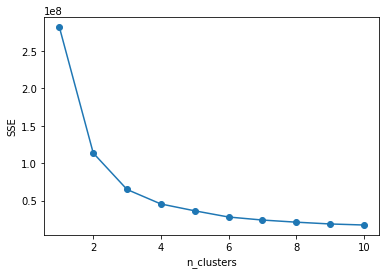

In [5]:
elbow(X_data)

In [6]:
sil(X_data)

[0.578]
[0.578 0.519]
[0.578 0.519 0.46 ]
[0.578 0.519 0.46  0.482]
[0.578 0.519 0.46  0.482 0.436]
[0.578 0.519 0.46  0.482 0.436 0.408]
[0.578 0.519 0.46  0.482 0.436 0.408 0.41 ]
[0.578 0.519 0.46  0.482 0.436 0.408 0.41  0.376]
[0.578 0.519 0.46  0.482 0.436 0.408 0.41  0.376 0.333]


## 시각화

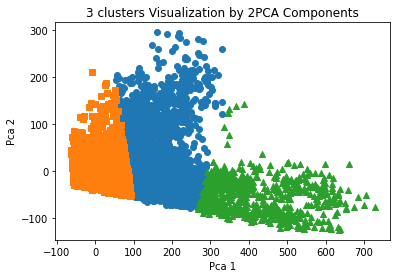

In [7]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2) #시각화를 위해 2개의 변수로 줄여준다
pca_data=pca.fit_transform(X_data)
X_data['pca_x']=pca_data[:,0] # X_data를 'pca_x', 'pca_y' 2개의 변수로 축소
X_data['pca_y']=pca_data[:,1]
Marker0_ind=X_data[X_data['cluster']==0].index
Marker1_ind=X_data[X_data['cluster']==1].index
Marker2_ind=X_data[X_data['cluster']==2].index
plt.scatter(x=X_data.loc[Marker0_ind, 'pca_x'], y=X_data.loc[Marker0_ind, 'pca_y'], marker='o')
plt.scatter(x=X_data.loc[Marker1_ind, 'pca_x'], y=X_data.loc[Marker1_ind, 'pca_y'], marker='s')
plt.scatter(x=X_data.loc[Marker2_ind, 'pca_x'], y=X_data.loc[Marker2_ind, 'pca_y'], marker='^')
plt.xlabel('Pca 1'); plt.ylabel('Pca 2')
plt.title('3 clusters Visualization by 2PCA Components')
plt.show()

# 인공신경망

## MLP Regressor 

In [8]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

X, y=make_regression(n_samples=200, random_state=0)
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=0)
MLP_clf=MLPRegressor(random_state=1, max_iter=500)
regr=MLP_clf.fit(X_train, y_train)
print('예측값:',regr.predict(X_test[:2]))
print('R2: ',regr.score(X_test, y_test))
print('최적 params: ', regr.get_params)

예측값: [-5.13552128 80.94220874]
R2:  0.2554764519808397
최적 params:  <bound method BaseEstimator.get_params of MLPRegressor(max_iter=500, random_state=1)>


## MLP Classifier 

In [9]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv('D:\Machine Learning\ADP-master\data/bikeshare.csv')

# type별로 컬럼 분류
col_id = []
col_dt = ['datetime']
col_cat = ['season']
col_int = ['weather', 'humidity','casual','registered','count']
col_float = ['temp','atemp','windspeed']
col_bool = ['holiday','workingday']

col_num = col_int + col_float
data['datetime'] = pd.to_datetime(data['datetime'])
data[col_cat]= data[col_cat].astype('str')
data[col_int] = data[col_int].astype('int', errors='ignore')
data[col_float] = data[col_float].astype('float')

data.loc[data['count'] <= 150, 'y1'] = 0
data.loc[(data['count']>150)&(data['count'] <= 300), 'y1'] = 1
data.loc[(data['count']>300)&(data['count'] <= 450), 'y1'] = 2
data.loc[data['count'] > 450, 'y1'] = 3
Data=data[['holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'y1']]
x_data=Data.drop(['y1'], axis=1, inplace=False)
y_data=Data['y1']

In [10]:
from sklearn.model_selection import train_test_split
array=Data.values
X=array[:, 0:9]
Y=array[:,9]
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.2, random_state=15)

In [11]:
X

array([[  0.    ,   0.    ,   1.    , ...,   0.    ,   3.    ,  13.    ],
       [  0.    ,   0.    ,   1.    , ...,   0.    ,   8.    ,  32.    ],
       [  0.    ,   0.    ,   1.    , ...,   0.    ,   5.    ,  27.    ],
       ...,
       [  0.    ,   1.    ,   1.    , ...,  15.0013,   4.    , 164.    ],
       [  0.    ,   1.    ,   1.    , ...,   6.0032,  12.    , 117.    ],
       [  0.    ,   1.    ,   1.    , ...,   8.9981,   4.    ,  84.    ]])

In [12]:
Y

array([0., 0., 0., ..., 1., 0., 0.])

In [13]:
from sklearn.neural_network import MLPClassifier
clf=MLPClassifier(hidden_layer_sizes=(9,9), learning_rate_init=0.005, max_iter=300, random_state=0, verbose=1) #은닉층 9개, 9개로 2층
clf.fit(X_train, y_train)
y_train_hat=clf.predict(X_train)
y_test_hat=clf.predict(X_test)

from sklearn import metrics
print(metrics.classification_report(y_train, y_train_hat))
print(metrics.classification_report(y_test, y_test_hat))

Iteration 1, loss = 3.77395580
Iteration 2, loss = 0.60993962
Iteration 3, loss = 0.43463782
Iteration 4, loss = 0.39918895
Iteration 5, loss = 0.37220476
Iteration 6, loss = 0.36359513
Iteration 7, loss = 0.34847932
Iteration 8, loss = 0.33571705
Iteration 9, loss = 0.32658136
Iteration 10, loss = 0.31936942
Iteration 11, loss = 0.32770235
Iteration 12, loss = 0.31773182
Iteration 13, loss = 0.31155562
Iteration 14, loss = 0.29835496
Iteration 15, loss = 0.28872059
Iteration 16, loss = 0.29672053
Iteration 17, loss = 0.28705274
Iteration 18, loss = 0.28320213
Iteration 19, loss = 0.28042914
Iteration 20, loss = 0.26984439
Iteration 21, loss = 0.26612351
Iteration 22, loss = 0.25855639
Iteration 23, loss = 0.26201847
Iteration 24, loss = 0.25507557
Iteration 25, loss = 0.24114382
Iteration 26, loss = 0.23926515
Iteration 27, loss = 0.23529499
Iteration 28, loss = 0.22423268
Iteration 29, loss = 0.21902924
Iteration 30, loss = 0.20511776
Iteration 31, loss = 0.19634490
Iteration 32, los

In [14]:
from sklearn.model_selection import GridSearchCV
params={'activation': ['logistic', 'tanh', 'relu'], 'hidden_layer_sizes':[(3,9), (9,9)]}
gridsearch=GridSearchCV(estimator=MLPClassifier(max_iter=300), param_grid=params, cv=5, verbose=1, n_jobs=-1)
gridsearch.fit(X_train, y_train)
print('cv_results_: ',gridsearch.cv_results_)
print('best_params_: ',gridsearch.best_params_)
print('best_score_: ', gridsearch.best_score_)
print('best_estimator_:',gridsearch.best_estimator_)
Y_train_hat=gridsearch.predict(X_train)
Y_test_hat=gridsearch.predict(X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
cv_results_:  {'mean_fit_time': array([8.03188324, 8.17088737, 7.19262953, 7.37895665, 7.71480041,
       9.08316021]), 'std_fit_time': array([0.35861121, 0.64862354, 1.68122339, 1.14407896, 0.31249747,
       0.66176482]), 'mean_score_time': array([0.00229087, 0.0023581 , 0.00240407, 0.00379362, 0.00190277,
       0.00251541]), 'std_score_time': array([0.0009925 , 0.00044476, 0.00073656, 0.00250672, 0.00019608,
       0.00100432]), 'param_activation': masked_array(data=['logistic', 'logistic', 'tanh', 'tanh', 'relu', 'relu'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_hidden_layer_sizes': masked_array(data=[(3, 9), (9, 9), (3, 9), (9, 9), (3, 9), (9, 9)],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'activation': 'logistic', 'hidden_layer_sizes': (3, 9)}, {'activation': 'lo

In [15]:
print(metrics.classification_report(y_train, Y_train_hat))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      4455
         1.0       0.98      0.99      0.98      2260
         2.0       0.98      0.96      0.97      1105
         3.0       0.97      0.98      0.98       888

    accuracy                           0.99      8708
   macro avg       0.98      0.98      0.98      8708
weighted avg       0.99      0.99      0.99      8708



In [16]:
print(metrics.classification_report(y_test, Y_test_hat))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1116
         1.0       0.98      0.99      0.98       573
         2.0       0.97      0.97      0.97       274
         3.0       0.98      0.98      0.98       215

    accuracy                           0.99      2178
   macro avg       0.98      0.98      0.98      2178
weighted avg       0.99      0.99      0.99      2178

